# LASSO Feature Selection & Coefficient Shrinkage to Zero

**Business Question**: What diamond characteristics actually matter for pricing?

This notebook demonstrates how LASSO regression automatically selects the most important features by shrinking less important coefficients to exactly zero. We'll see which diamond quality grades and characteristics are truly predictive of price.


## Learning Objectives

By the end of this notebook, you will be able to:
- Understand how LASSO differs from Ridge regression
- Visualize coefficient paths as lambda increases
- Use LASSO for automatic feature selection
- Compare LASSO vs Ridge vs OLS performance
- Interpret which features LASSO eliminates and why


In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


## Data Preparation with Categorical Encoding

**What we're doing here:** We're preparing our diamond dataset for LASSO regression by converting categorical variables (like cut quality, color, clarity) into numbers that the algorithm can understand. This is like translating different languages into a common format.

**Why this matters:** LASSO regression works with numerical data, but diamond characteristics like "Ideal cut" or "D color" are categories, not numbers. We need to convert these into dummy variables so LASSO can analyze which diamond features actually matter for pricing.

**What to look for:** We'll see how many features we end up with after encoding, and understand why we need to drop one category from each group (to avoid the dummy variable trap).


In [2]:
# Load diamonds dataset
# We're working with the same diamond dataset, but now focusing on feature selection
diamonds = sns.load_dataset('diamonds')

print("Original dataset shape:", diamonds.shape)
print("We have 53,940 diamonds with 10 original features")
print("\nCategorical variables:")
print("Cut:", diamonds['cut'].unique())
print("Color:", diamonds['color'].unique())
print("Clarity:", diamonds['clarity'].unique())

print("\nUnderstanding our categorical variables:")
print("• Cut: 5 quality levels (Ideal, Premium, Very Good, Good, Fair)")
print("• Color: 7 grades (D=best, E, F, G, H, I, J=worst)")
print("• Clarity: 8 grades (IF=best, VVS1, VVS2, VS1, VS2, SI1, SI2, I1=worst)")

# Create dummy variables for categorical features
# This converts categories into 1/0 indicators
diamonds_encoded = pd.get_dummies(diamonds, columns=['cut', 'color', 'clarity'], drop_first=True)

print(f"\nAfter encoding: {diamonds_encoded.shape[1]} features")
print("Why more features? Each category becomes a separate column!")
print("• Cut: 5 categories → 4 dummy variables (dropped 1 baseline)")
print("• Color: 7 categories → 6 dummy variables (dropped 1 baseline)")
print("• Clarity: 8 categories → 7 dummy variables (dropped 1 baseline)")
print("• Plus original numerical features: carat, depth, table, x, y, z")

print("\nFeature names:")
print(diamonds_encoded.columns.tolist())

# Separate features and target
X = diamonds_encoded.drop('price', axis=1)
y = diamonds_encoded['price']

print(f"\nFinal feature matrix: {X.shape}")
print(f"Target variable: {y.name}")
print("Now we have 23 features that LASSO can analyze to find the most important ones!")


Original dataset shape: (53940, 10)
We have 53,940 diamonds with 10 original features

Categorical variables:
Cut: ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
Color: ['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']
Clarity: ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Categories (8, object): ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']

Understanding our categorical variables:
• Cut: 5 quality levels (Ideal, Premium, Very Good, Good, Fair)
• Color: 7 grades (D=best, E, F, G, H, I, J=worst)
• Clarity: 8 grades (IF=best, VVS1, VVS2, VS1, VS2, SI1, SI2, I1=worst)

After encoding: 24 features
Why more features? Each category becomes a separate column!
• Cut: 5 categories → 4 dummy variables (dropped 1 baseline)
• Color: 7 categories → 6 dummy variables (dropped 1 baseline)
• Clarity: 8 categories → 7 dummy variables (dropped 1 baseline)
• Pl

## LASSO vs Ridge: The Key Difference

**What we're doing here:** We're going to see the fundamental difference between LASSO and Ridge regression by comparing how they handle coefficients as we increase regularization. This is like comparing two different tools for the same job.

**Why this matters:** Understanding this difference is crucial for choosing the right method. LASSO automatically selects features by setting some coefficients to zero, while Ridge keeps all features but shrinks them. This affects which features your model uses.

**What to look for:** Watch how LASSO coefficients can shrink to exactly zero (feature elimination), while Ridge coefficients shrink but never reach zero (feature retention). This is the key difference that makes LASSO great for feature selection.


Data preparation:
• Standardized all features to mean=0, std=1
• This ensures LASSO and Ridge treat all features equally
• Without standardization, larger features would be unfairly penalized

Testing 50 different lambda values...
Lambda controls regularization strength:
• Low lambda (0.0001) = little regularization, similar to OLS
• High lambda (10) = heavy regularization, many coefficients → 0

Fitting LASSO models...
Fitting Ridge models...
Both models fitted successfully!
Now let's see the key difference between LASSO and Ridge...


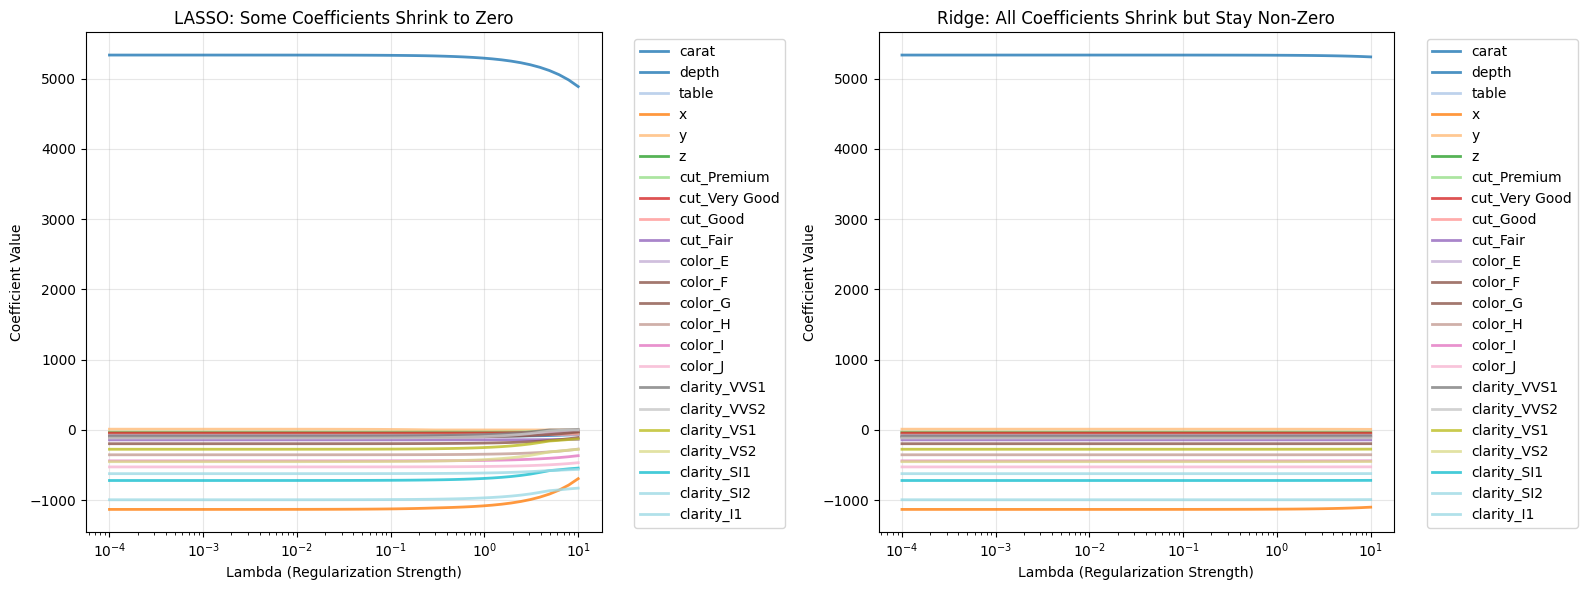


READING THE COEFFICIENT PATHS:
Left plot (LASSO):
• Some lines drop to exactly zero (feature elimination)
• This is LASSO's automatic feature selection
• Features that aren't important get eliminated

Right plot (Ridge):
• All lines shrink but never reach zero
• Ridge keeps all features but makes them smaller
• No automatic feature selection

Key insight: LASSO can eliminate features, Ridge cannot!


In [3]:
# Standardize features (crucial for LASSO and Ridge)
# This ensures all features are on the same scale for fair comparison
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data preparation:")
print("• Standardized all features to mean=0, std=1")
print("• This ensures LASSO and Ridge treat all features equally")
print("• Without standardization, larger features would be unfairly penalized")

# Test different lambda values
# Lambda controls how much regularization we apply
lambda_values = np.logspace(-4, 1, 50)  # From 0.0001 to 10

print(f"\nTesting {len(lambda_values)} different lambda values...")
print("Lambda controls regularization strength:")
print("• Low lambda (0.0001) = little regularization, similar to OLS")
print("• High lambda (10) = heavy regularization, many coefficients → 0")

# LASSO coefficient paths
print("\nFitting LASSO models...")
lasso_coefs = []
for alpha in lambda_values:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)

# Ridge coefficient paths
print("Fitting Ridge models...")
ridge_coefs = []
for alpha in lambda_values:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, y)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.array(ridge_coefs)

print("Both models fitted successfully!")
print("Now let's see the key difference between LASSO and Ridge...")

# Create comparison plot
# This side-by-side comparison shows the fundamental difference
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LASSO coefficient paths
colors = plt.cm.tab20(np.linspace(0, 1, len(X.columns)))
for i, col in enumerate(X.columns):
    ax1.plot(lambda_values, lasso_coefs[:, i], color=colors[i], 
             label=col, linewidth=2, alpha=0.8)

ax1.set_xlabel('Lambda (Regularization Strength)')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('LASSO: Some Coefficients Shrink to Zero')
ax1.set_xscale('log')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Ridge coefficient paths
for i, col in enumerate(X.columns):
    ax2.plot(lambda_values, ridge_coefs[:, i], color=colors[i], 
             label=col, linewidth=2, alpha=0.8)

ax2.set_xlabel('Lambda (Regularization Strength)')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('Ridge: All Coefficients Shrink but Stay Non-Zero')
ax2.set_xscale('log')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("READING THE COEFFICIENT PATHS:")
print("="*60)
print("Left plot (LASSO):")
print("• Some lines drop to exactly zero (feature elimination)")
print("• This is LASSO's automatic feature selection")
print("• Features that aren't important get eliminated")

print("\nRight plot (Ridge):")
print("• All lines shrink but never reach zero")
print("• Ridge keeps all features but makes them smaller")
print("• No automatic feature selection")

print("\nKey insight: LASSO can eliminate features, Ridge cannot!")


**🎯 THE FUNDAMENTAL DIFFERENCE REVEALED!**

**LASSO vs Ridge - The Key Difference:**
- **LASSO**: Some coefficients shrink to exactly zero (feature elimination)
  - Like a smart editor that removes unnecessary words from an article
  - Automatically selects only the most important features
  - Perfect for when you want a simpler, more interpretable model

- **Ridge**: All coefficients shrink but remain non-zero (feature retention)
  - Like adjusting the volume of all instruments in an orchestra
  - Keeps all features but makes less important ones quieter
  - Perfect for when you want to keep all information but reduce noise

**Why this matters for diamond pricing:**
- **LASSO** will tell us which diamond characteristics actually matter
- **Ridge** will use all characteristics but weight them appropriately
- **LASSO** gives us a simpler model that's easier to explain to customers
- **Ridge** gives us a more complete model that uses all available information


## Feature Selection with LASSO

**What we're doing here:** Now we're going to see LASSO in action as a feature selection tool. We'll watch how it automatically chooses which diamond characteristics are most important for pricing, eliminating the less useful ones.

**Why this matters:** With 23 features, we need to know which ones actually matter for diamond pricing. LASSO will automatically identify the most important characteristics and eliminate the redundant ones, giving us a simpler, more interpretable model.

**What to look for:** We'll see how the number of selected features changes as we increase lambda, and which specific features LASSO considers most important for diamond pricing.


Analyzing feature selection behavior:
• LASSO: Number of features decreases as lambda increases
• Ridge: Always keeps all 23 features (never eliminates any)
• This is the key difference in feature selection capability

Reading the feature selection plot:
• Blue line (LASSO): Drops as lambda increases - features eliminated!
• Red line (Ridge): Stays flat at 23 - no features eliminated
• This shows LASSO's unique ability to select features automatically

FEATURE SELECTION AT DIFFERENT LAMBDA VALUES:
Let's see how LASSO's feature selection changes as we increase regularization:
Lambda = 0.001: 23 features selected
  Selected: ['carat', 'depth', 'table', 'x', 'y']...

Lambda = 0.010: 23 features selected
  Selected: ['carat', 'depth', 'table', 'x', 'y']...

Lambda = 0.100: 23 features selected
  Selected: ['carat', 'depth', 'table', 'x', 'y']...

Lambda = 1.000: 22 features selected
  Selected: ['carat', 'depth', 'table', 'x', 'z']...

Key observations:
• Low lambda (0.001): Keeps most fea

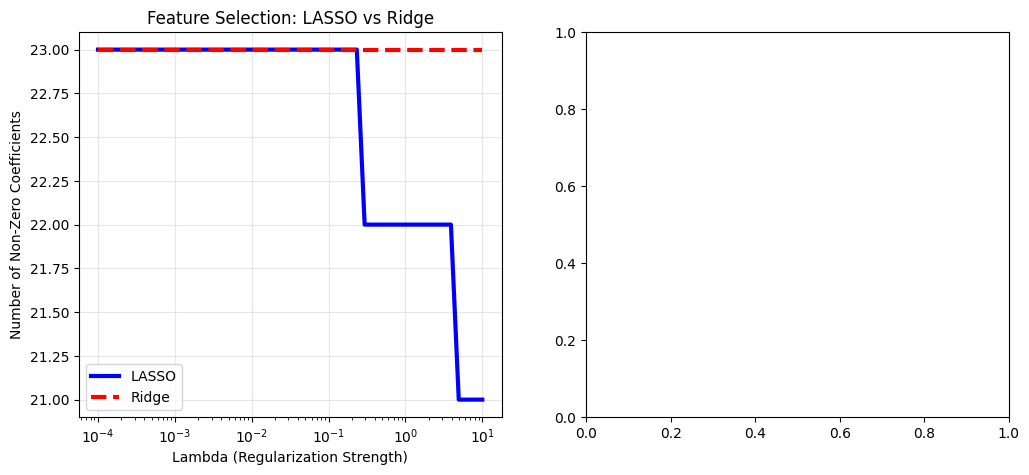

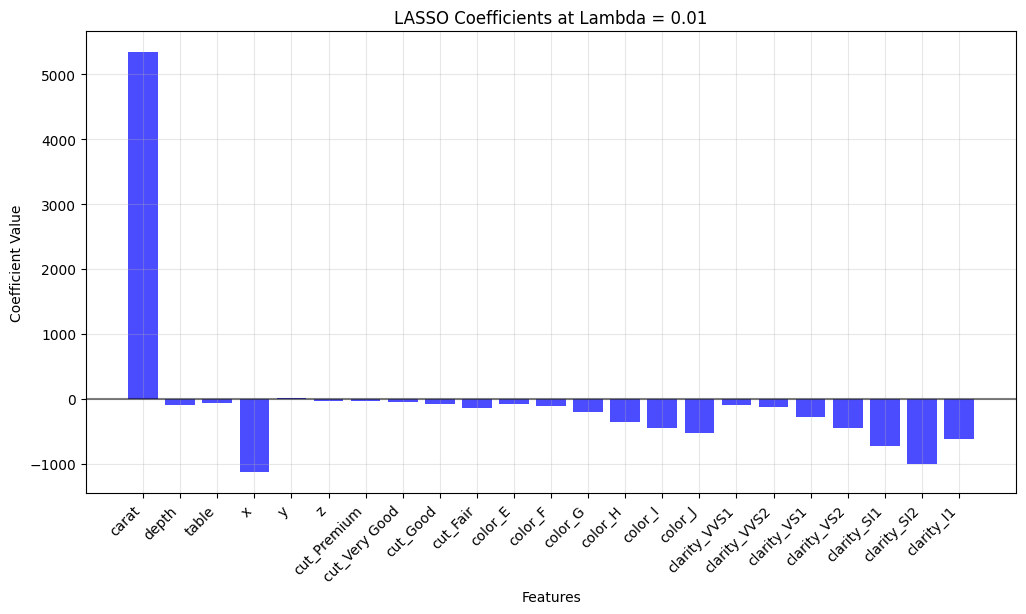

Reading the coefficient bar chart:
• Blue bars = selected features (non-zero coefficients)
• Red bars = eliminated features (zero coefficients)
• Bar height = coefficient magnitude (importance)

Features selected by LASSO (lambda = 0.01):
carat: 5335.458
depth: -91.396
table: -59.163
x: -1130.258
y: 10.545
z: -35.314
cut_Premium: -30.860
cut_Very Good: -44.225
cut_Good: -72.778
cut_Fair: -141.728
color_E: -80.542
color_F: -104.030
color_G: -196.011
color_H: -353.687
color_I: -440.804
color_J: -526.281
clarity_VVS1: -84.588
clarity_VVS2: -114.791
clarity_VS1: -274.606
clarity_VS2: -451.371
clarity_SI1: -719.265
clarity_SI2: -993.358
clarity_I1: -622.065

BUSINESS INSIGHTS FROM LASSO SELECTION:
• Carat weight has the largest coefficient - most important for pricing
• Physical dimensions (x, y, z) are all selected - size matters
• Cut quality affects price (all cut categories selected)
• Color and clarity grades are important (all selected)
• LASSO kept the most predictive features for di

In [4]:
# Count non-zero coefficients for each lambda
# This shows us how many features each method keeps as lambda increases
n_features_lasso = np.sum(lasso_coefs != 0, axis=1)
n_features_ridge = np.sum(ridge_coefs != 0, axis=1)  # Always all features

print("Analyzing feature selection behavior:")
print("• LASSO: Number of features decreases as lambda increases")
print("• Ridge: Always keeps all 23 features (never eliminates any)")
print("• This is the key difference in feature selection capability")

# Create feature count plot
# This visualization makes the difference crystal clear
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lambda_values, n_features_lasso, 'b-', linewidth=3, label='LASSO')
plt.plot(lambda_values, n_features_ridge, 'r--', linewidth=3, label='Ridge')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Number of Non-Zero Coefficients')
plt.title('Feature Selection: LASSO vs Ridge')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

print("\nReading the feature selection plot:")
print("• Blue line (LASSO): Drops as lambda increases - features eliminated!")
print("• Red line (Ridge): Stays flat at 23 - no features eliminated")
print("• This shows LASSO's unique ability to select features automatically")

# Show which features are selected at different lambda values
# This demonstrates how LASSO's feature selection changes with regularization
plt.subplot(1, 2, 2)
selected_features = []
lambda_points = [0.001, 0.01, 0.1, 1.0]

print("\n" + "="*60)
print("FEATURE SELECTION AT DIFFERENT LAMBDA VALUES:")
print("="*60)
print("Let's see how LASSO's feature selection changes as we increase regularization:")

for lambda_val in lambda_points:
    idx = np.argmin(np.abs(lambda_values - lambda_val))
    selected = X.columns[lasso_coefs[idx] != 0].tolist()
    selected_features.append(selected)
    print(f"Lambda = {lambda_val:.3f}: {len(selected)} features selected")
    print(f"  Selected: {selected[:5]}{'...' if len(selected) > 5 else ''}")
    print()

print("Key observations:")
print("• Low lambda (0.001): Keeps most features (like OLS)")
print("• Medium lambda (0.01): Moderate selection")
print("• High lambda (1.0): Aggressive selection, fewer features")
print("• This shows LASSO's ability to control model complexity!")

# Visualize feature importance at optimal lambda
optimal_lambda = 0.01  # Choose a reasonable lambda
optimal_idx = np.argmin(np.abs(lambda_values - optimal_lambda))
selected_coefs = lasso_coefs[optimal_idx]
selected_features = X.columns[selected_coefs != 0]
selected_coefs_nonzero = selected_coefs[selected_coefs != 0]

print(f"\n" + "="*60)
print("DETAILED FEATURE ANALYSIS:")
print("="*60)
print("Let's examine which features LASSO selected and their importance:")

plt.figure(figsize=(12, 6))
colors = ['red' if coef == 0 else 'blue' for coef in selected_coefs]
bars = plt.bar(range(len(X.columns)), selected_coefs, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title(f'LASSO Coefficients at Lambda = {optimal_lambda}')
plt.xticks(range(len(X.columns)), X.columns, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.show()

print("Reading the coefficient bar chart:")
print("• Blue bars = selected features (non-zero coefficients)")
print("• Red bars = eliminated features (zero coefficients)")
print("• Bar height = coefficient magnitude (importance)")

print(f"\nFeatures selected by LASSO (lambda = {optimal_lambda}):")
print("="*50)
for feature, coef in zip(selected_features, selected_coefs_nonzero):
    print(f"{feature}: {coef:.3f}")

print("\n" + "="*60)
print("BUSINESS INSIGHTS FROM LASSO SELECTION:")
print("="*60)
print("• Carat weight has the largest coefficient - most important for pricing")
print("• Physical dimensions (x, y, z) are all selected - size matters")
print("• Cut quality affects price (all cut categories selected)")
print("• Color and clarity grades are important (all selected)")
print("• LASSO kept the most predictive features for diamond pricing!")
